---
layout:     post
title:      "Dollars to Doughnuts"
subtitle:   "Where do my food dollars go?"
date:       2017-04-06 12:00:00
author:     Andrew
header-img: img/posts/food_spending/peppers_bg.jpg
header-credit: https://unsplash.com/@mobography
tags:       programming dynamics sympy python
---

Today's post is a (relatively) quick one to do some visualization on my financial data.  Specifically, I was interested in whether some concious changes I had made in my dietary habits have materialized into measurable savings.

To date, I haven't really focused too much on reducing my food spending.  I keep a budget for it, but pretty regularly exceed it.  However, in February I took a close look at how much I was actually spending and tried to take some steps to reduce my spending.  The main areas that I looked to cut were eating take-out and getting breakfast & lunch at work every day.  I've been making some concious efforts in those areas over the past ~4 weeks or so, including cooking large batch meals to bring for lunches at work.

In the post I'm going to run through the analysis I did to determine whether my changes had a financial impact.

Fine print:
* I was on vacation in the beginning of January, using cash only, so those transactions won't appear.
* I didn't remove anomolies, like covering a meal for a group and getting paid in cash.
* Some restaurants show up in Alcohol & Bars.

I use [mint](https://www.mint.com/) to track and categorize my finances.  It pulls transaction information from my bank accounts, and each month I run through the transactions from the previous month to make sure they were correctly categorized.  

For the analysis, I used my programming language of choice, [python](https://www.python.org/), with the [matplotlib](http://matplotlib.org/), [numpy](http://www.numpy.org/), and [scipy](https://www.scipy.org/) libraries.

This post will be interleaving the code and my commentary, so if you're not interested in the code, you can skip over those sections.  I've done my best to make it a coherent article even without the code.  The code to create the plots is very verbose, so it's definitely safe to skip that.

In [1]:
import csv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import datetime, timedelta, date
from itertools import groupby, dropwhile, accumulate
from decimal import Decimal, getcontext
from pprint import pprint
from scipy import stats

%matplotlib inline

getcontext().prec = 6
preview_size = 5

mpl.rcParams['figure.figsize'] = (12.0, 10.0)
mpl.rcParams['font.size'] = 15

# The Data

To start, I downloaded all my transactions from mint as a .csv (comma separated values) file. In excel, I removed everything except the columns for date, amount and category. I could have done some of that in python, but it was just easier to do it ahead of time.

Now in python, let's read in the file.  Python's `csv` module makes it easy to already separate the data.  The result is a list of all the rows, where each row is already split up into the data columns.

In [2]:
with open('transactions.csv','r') as transactions_csv:
    transactions = list(csv.reader(transactions_csv, delimiter=','))
    

pprint(transactions[:preview_size])

[['Date', 'Amount', 'Category'],
 ['4/06/2017', '1.34', 'Lunch at Work'],
 ['4/06/2017', '2.55', 'Lunch at Work'],
 ['4/05/2017', '7.22', 'Restaurants'],
 ['4/05/2017', '10.25', 'Movies & DVDs']]


The first step to make the data usable is to remove the column header text.  Indexing `transactions` by `[1:]` will take everything in `transactions` except the first row (python indexing starts at `0`).

In [3]:
transactions = transactions[1:]

pprint(transactions[:preview_size])

[['4/06/2017', '1.34', 'Lunch at Work'],
 ['4/06/2017', '2.55', 'Lunch at Work'],
 ['4/05/2017', '7.22', 'Restaurants'],
 ['4/05/2017', '10.25', 'Movies & DVDs'],
 ['4/06/2017', '1.18', 'Lunch at Work']]


Right now, all the data is being stored as strings, which makes it difficult to do any kind of sorting or math.

To resolve this, let's make a new class (`Transaction`) to store this information.  The attributes of `Transaction` will be:
* **date**: (`datetime.datetime`) The date string will be turned into an actual date object in python, so we can filter and sort by date.
* **amount**: (`Decimal`) make sure to not use floating point for currencies![^floating_bitcoin]
* **category**: (`string`)

Additionally, I'll add a `__str__` method to make things look nice when they get printed out.

In [4]:
class Transaction(object):
    
    def __init__(self, date, amount, category):
        self.date = datetime.strptime(date,"%m/%d/%Y")
        self.amount = Decimal(amount)
        self.category = category
    
    def __str__(self):
        return "${0:>6.2f} on {1:>8} ({2})".format(
            self.amount,
            self.date.strftime("%m/%d/%y"),
            self.category)
    
    def __repr__(self):
        return self.__str__()

In [5]:
transactions = [Transaction(*transaction_data) for transaction_data in transactions]

pprint(transactions[:preview_size])

[$  1.34 on 04/06/17 (Lunch at Work),
 $  2.55 on 04/06/17 (Lunch at Work),
 $  7.22 on 04/05/17 (Restaurants),
 $ 10.25 on 04/05/17 (Movies & DVDs),
 $  1.18 on 04/06/17 (Lunch at Work)]


Currently, `transactions` contains all of my transactions regardless of category.  This code will filter out any transactions with categories that don't appear in `food_categories`.

In [6]:
food_categories = ['Alcohol & Bars',
'Coffee Shops',
'Fast Food',
'Groceries',
'Restaurants',
'Lunch at Work',
'Snacks']

transactions = [trans for trans in transactions if trans.category in food_categories]

pprint(transactions[:preview_size])

[$  1.34 on 04/06/17 (Lunch at Work),
 $  2.55 on 04/06/17 (Lunch at Work),
 $  7.22 on 04/05/17 (Restaurants),
 $  1.18 on 04/06/17 (Lunch at Work),
 $  1.71 on 04/05/17 (Lunch at Work)]


Now let's make sure the data is sorted (this is important later when we want to group the data by date).  This will sort the transactions first by `date`, then by `category` for transactions that happen on the same date.

In [7]:
transactions.sort(key = lambda trans: (trans.date, trans.category))

pprint(transactions[:preview_size])

[$  4.00 on 09/17/10 (Restaurants),
 $  7.68 on 09/17/10 (Restaurants),
 $ 11.95 on 09/19/10 (Restaurants),
 $ 10.50 on 09/20/10 (Alcohol & Bars),
 $ 81.22 on 09/29/10 (Fast Food)]


Next, let's trim our date range down to start from last October.  That will show some historical data, but not enough to hide a trend over the last few months.

In [8]:
cutoff_date = datetime(day=1, month=10, year=2016)

transactions = [trans for trans in transactions if trans.date >= cutoff_date]

pprint(transactions[:preview_size])

[$ 35.16 on 10/01/16 (Alcohol & Bars),
 $  9.92 on 10/01/16 (Alcohol & Bars),
 $  2.12 on 10/01/16 (Fast Food),
 $ 16.70 on 10/01/16 (Groceries),
 $  6.20 on 10/01/16 (Lunch at Work)]


# Daily Spending

`transactions` is now a list of all transactions, sorted by date.  The easiest thing to start with is a simple bar graph of daily spending.  I anticipate that it won't be particularly informative (might be very noisy), but it might hightlight if we've done something wrong manipulating the data to this point.

In order to do this, we first need to group the transactions by date.  Python has a function `groupby`, which does exactly this given the data is sorted (which we've already done).

Once the transactions are grouped by date, they're summed up and the dates and amounts are added to lists for plotting later.

In [9]:
grouped_transactions = groupby(transactions, key = lambda trans: trans.date)

dates = []
daily_sums = []

for date, transaction_group in grouped_transactions:
    dates.append(date)
    daily_sums.append(sum([trans.amount for trans in transaction_group]))

In [10]:
def format_x_axis_dates(fig, ax):
    days = mdates.DayLocator()
    months = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%B %-d')
    
    fig.autofmt_xdate()
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(days)

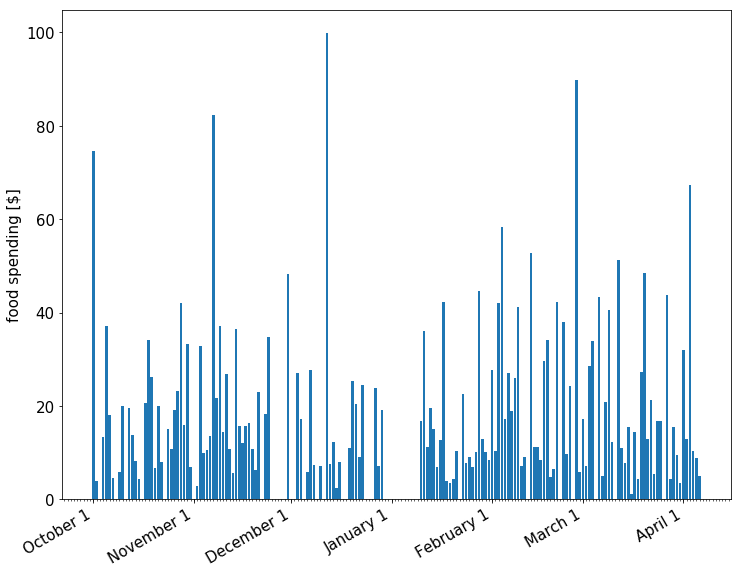

In [11]:
fig, ax = plt.subplots(1)
ax.bar(dates, daily_sums)
plt.ylabel("food spending [$]")
format_x_axis_dates(fig, ax)
plt.show()

As expected, the data looks reasonable, but not particularly useful to identifying long-term trends.  The large variation in daily spending makes it difficult to identify anything from the bar chart.

# Moving Average of Daily Spending

Because of these short term fluctuations, a different approach might yield more information.

Conveniently, a solution for just this problem already exists!  Moving averages are commonly used with time series data to smooth out short-term fluctuations and highlight longer-term trends or cycles[^wiki_ma].  In this case, I'll be using a moving average to average my spending over the previous 30 days.

We'll be using a simple moving average, where the data for a particular date represents the unweighted average spending over the previous 30 days.

`calculate_moving_average` is the function that will actually do the calculation.  Given a list of dates, daily sums for each date, and a requested time span to do the averaging over it will return two lists, one of dates, and one of the previous 30 day average sums.

In [12]:
def calculate_moving_average(dates, daily_sums, time_span):

    # index will be the date that we'll use to loop through our data
    # it starts time_frame days from the beginning, which the first 
    # day that we have enough data from previous days to average.
    # index is the end of our window on each calculation.
    start = dates[0]
    end = dates[-1]
    
    index = start + timedelta(days = time_span-1)

    moving_averages = []
    moving_dates = []
    
    # stop once the index has reached the last day, stop calculating.
    while index <= end:

        # on each loop, filter out any transactions that don't fall in our window
        window = [trans for trans in transactions
                  if (index - timedelta(days = time_span)) <= trans.date <= index]

        # sum all transactions that fall in the window
        # then average them
        # then add that average to our result
        moving_averages.append(sum([trans.amount for trans in window])/time_span)

        # we're also keeping track of the dates for plotting later
        moving_dates.append(index)

        # move the index date for the next iteration
        index = index + timedelta(days = 1)
        
    # return the date and sums lists
    return [moving_dates, moving_averages]

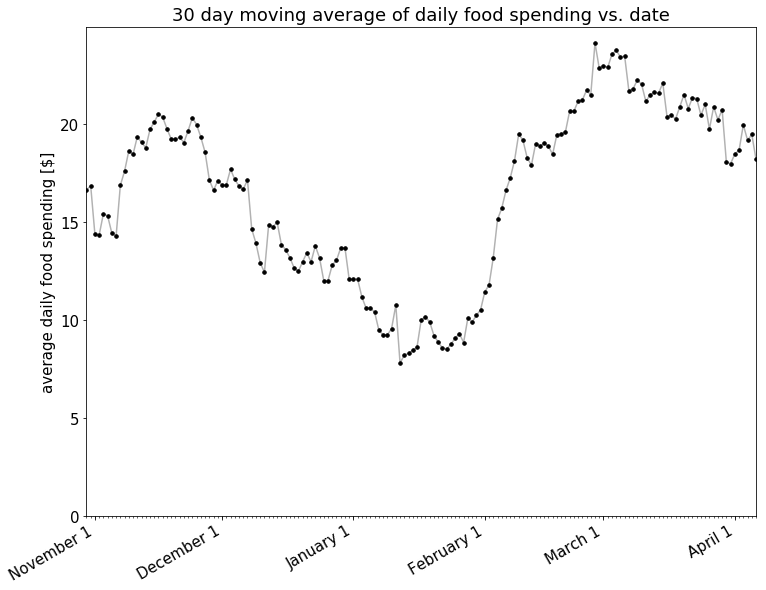

In [13]:
time_span = 30

moving_dates, moving_averages = calculate_moving_average(dates, daily_sums, time_span)

fig, ax = plt.subplots(1)

ax.plot(moving_dates,moving_averages,'k', alpha=0.3)
ax.plot(moving_dates,moving_averages,'k.', markersize=7)

format_x_axis_dates(fig, ax)

plt.ylabel("average daily food spending [$]")

ax.set_xlim([moving_dates[0],moving_dates[-1]])
ax.set_ylim(0)
ax.set_title("{} day moving average of daily food spending vs. date".format(time_span))

plt.show()

Nothing definitive at this point except that my spending went up pretty solidly through January and February.

It also does appear that there is a decline in spending starting around March.  Let's look closer at the trend in 30 day moving average starting March 1st.

In [14]:
def calculate_moving_average_with_regression(dates, daily_sums, time_span, reg_start):

    moving_dates,moving_averages = calculate_moving_average(dates, daily_sums, time_span)

    reg_end = moving_dates[-1]

    reg_start_index = moving_dates.index(reg_start)

    date_nums = [mdates.date2num(dt) for dt in moving_dates[reg_start_index:]]
    float_nums = [float(num) for num in moving_averages[reg_start_index:]]

    m,b = np.polyfit(date_nums,float_nums,1)

    reg_x = [reg_start, reg_end]
    reg_y = [mdates.date2num(reg_start)*m+b, mdates.date2num(reg_end)*m+b]
    
    return moving_dates, moving_averages, reg_x, reg_y, m

In [15]:
def plot_moving_average_with_regression(moving_dates, moving_averages, reg_x, reg_y, m):
    fig, ax = plt.subplots(1)
    ax.plot(moving_dates,moving_averages,'k', alpha=0.3)
    ax.plot(moving_dates,moving_averages,'k.', markersize=7)

    format_x_axis_dates(fig, ax)

    plt.ylabel("average daily food spending [$]")
    ax.set_xlim([reg_x[0] - timedelta(days=35), moving_dates[-1]])
    ax.set_ylim(0)
    ax.set_title("{} day moving average of daily food spending vs. date".format(time_span))
    ax.plot(reg_x,
            reg_y,
            'r--',
            label="linear regession {} to {}".format(reg_x[0].strftime("%m/%d/%y"),
                                                     reg_x[1].strftime("%m/%d/%y")))
    ax.legend(loc=3)

    ax.annotate("slope = -${0:.2f} / day".format(abs(m)), 
                xytext=(datetime(day=1,month=3,year=2017), 10), 
                xy=(reg_x[0], reg_y[0]),
                xycoords='data',
                ha='right',
                va='center',
                arrowprops=dict(facecolor='red', shrink=0.05))

    plt.show()

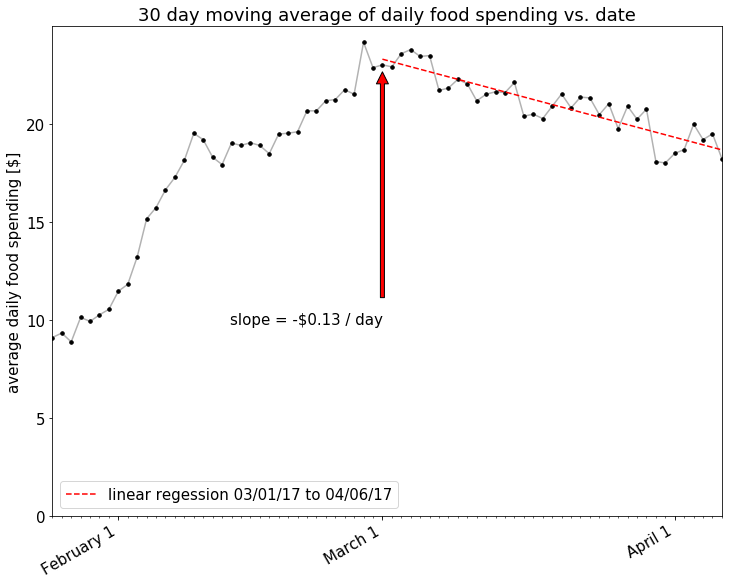

In [16]:
time_span = 30

plot_moving_average_with_regression(
    *calculate_moving_average_with_regression(dates, 
                                              daily_sums, 
                                              time_span, 
                                              datetime(day=1,month=3,year=2017)))


There looks to be a nice downward trend there!  How about if we look at an even shorter window, maybe only a 7 day moving average, to account for the relatively short amount of time that I've been making this effort?

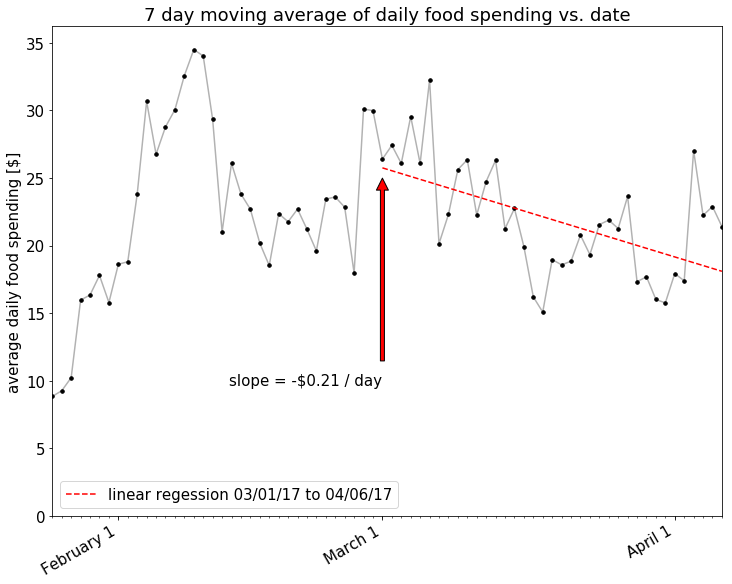

In [17]:
time_span = 7

plot_moving_average_with_regression(
    *calculate_moving_average_with_regression(dates, 
                                              daily_sums, 
                                              time_span, 
                                              datetime(day=1,month=3,year=2017)))

Looks like the effect is larger with the shorter time moving_averages average, but the correlation is much less strong.  In any case, it does appear that there's been some spending reduction over the last month or so.  I'll call it a tentative success.

So at first glance, it appears that my spending is going down.  However, I'm also interested in whether my spending is moving within the overall food category.  Specifically, I'm looking for my spending to transition from low-value (Restaurants, Lunch at Work) to more economic categories (Groceries).

Back to the overall time period, let's examine a stacked chart, showing how my spending is changing per category as well.

In [18]:
def calculate_stacked_moving_averages(dates, daily_sums, time_span):

    # index will be the date that we'll use to loop through our data
    # it starts n days from the beginning, which the first day that we
    # have enough data to average.  index is the end of our window
    # on each calculation
    start = dates[0]
    end = dates[-1]
    
    index = start + timedelta(days = time_span-1)

    moving_averages = []
    moving_dates = []
    
    # stop once the index has reached the last day, stop calculating.
    while index <= end:

        # on each loop, filter out any transactions that don't fall in our window
        window = [trans for trans in transactions
                  if (index - timedelta(days = time_span)) <= trans.date <= index]

        # re-sort each window of transactions by category
        window = sorted(list(window), key = lambda trans: trans.category)
    
        # place those averages into a dictionary
        # then we can extract them in the same order each time
        # initialize each category to 0
        stack = {cat:0 for cat in food_categories}
        for cat,cat_trans in groupby(window, lambda trans: trans.category):
            stack[cat] = float(sum([trans.amount for trans in cat_trans])/time_span)
        
        # make a list of all the stacked numbers
        moving_averages.append([stack[cat] for cat in food_categories])

        # we're also keeping track of the dates for plotting later
        moving_dates.append(index)

        # move the index date for the next iteration
        index = index + timedelta(days = 1)
        
    # return the date and sums lists
    return [moving_dates, moving_averages]


In [19]:
def reverse_legend_labels(axis):
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles = k[::-1], labels = food_categories[::-1], prop={'size':10}, loc=2)

In [20]:
def add_braces(ax, date, stack_indices, dates, stack_data):
    date_index = dates.index(date)
    
    accu = list(accumulate([stack_data[i][date_index] for i in range(len(stack_data))]))
    
    for stack in stack_indices:
        text = "{0:.1f}%".format(accu[stack+1]-accu[stack])
        x0 = date - timedelta(days = 8)
        y0 = (accu[stack+1]-accu[stack])/2 + accu[stack]
        x1 = date
        y1 = accu[stack]
        y2 = accu[stack+1]
        
        arrowprops = dict(arrowstyle="->",
                          connectionstyle="arc, armB=-30")

        kwargs =dict(xycoords='data',
                     ha='right',
                     va='center',
                     bbox=dict(boxstyle='square', fc='white'),
                     arrowprops=arrowprops)

        ax.annotate(text, xy=(x1,y2), xytext=(x0,y0), **kwargs)
        ax.annotate(text, xy=(x1,y1), xytext=(x0,y0), **kwargs)
        

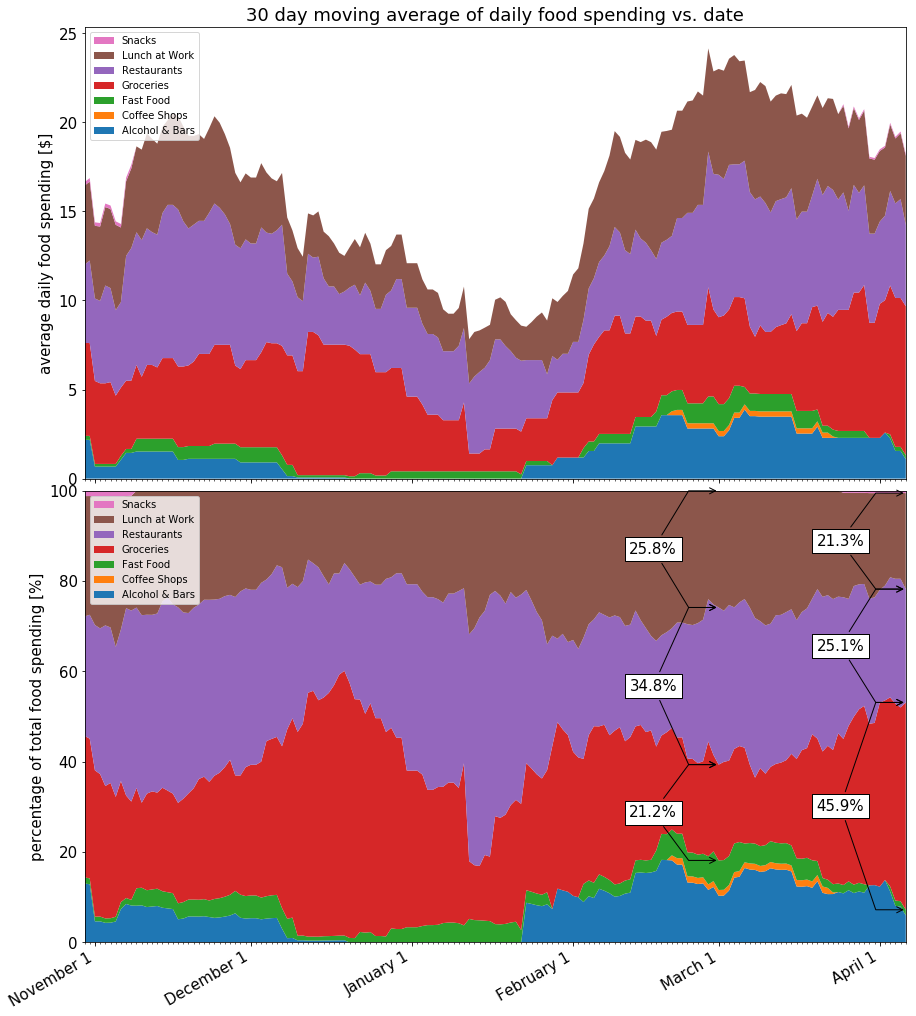

In [22]:
time_span = 30
    
moving_dates, moving_averages = calculate_stacked_moving_averages(dates,
                                                                  daily_sums,
                                                                  time_span)
    
y = np.row_stack(list(zip(*moving_averages)))
percent = y /  y.sum(axis=0).astype(float) * 100 

fig, (ax2, ax) = plt.subplots(2, facecolor='white', sharex=True, figsize=(12,16))
plt.tight_layout(pad=0, w_pad=0.5, h_pad=0)

k = ax.stackplot(moving_dates, percent)
k = ax2.stackplot(moving_dates, y)

reverse_legend_labels(ax)
reverse_legend_labels(ax2)

ax.set_ylabel("percentage of total food spending [%]")
ax.set_xlim([moving_dates[0],moving_dates[-1]])
ax.set_ylim([0,100])

format_x_axis_dates(fig, ax2)

ax2.set_title("{} day moving average of daily food spending vs. date".format(time_span))
ax2.set_ylabel("average daily food spending [$]")
    
add_braces(ax, datetime(day=1,month=3,year=2017), [2,3,4], moving_dates, percent)
add_braces(ax, moving_dates[-1], [2,3,4], moving_dates, percent)
    
plt.show()

# Summary

The 30 day MA over the last 5 weeks shows a downward trend, and the 7 day MA shows a stronger downward trend, with a weaker correlation.  The 100% stacked chart shows that my spending has shifted slightly in the way that I was hoping.  From the data that I've looked at, I'll call it a tentative success.  An extra month or two of data will confirm whether it's a lasting trend or just a fluctuation from another source.

Hope you enjoyed, let me know if you think there's anything I missed.

--Andrew



[^floating_bitcoin]: As an aside, here's a fun example of what can happen if you store currencies as floating point numbers: https://hackerone.com/reports/176461

[^wiki_ma]: https://en.wikipedia.org/wiki/Moving_average